In [ ]:
!python3 -m pip uninstall pillow

Uninstalling Pillow-7.0.0:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/PIL/*
    /usr/local/lib/python3.6/dist-packages/Pillow-7.0.0.dist-info/*
Proceed (y/n)? y
  Successfully uninstalled Pillow-7.0.0


In [ ]:
!python3 -m pip install Pillow --no-binary :all:

     |████████████████████████████████| 44.6MB 74kB/s 
Skipping wheel build for Pillow, due to binaries being disabled for it.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
    Running setup.py install for Pillow ... done


In [ ]:
!pip install livelossplot
!pip install tensorflow==2.1
#RESTART RUNTIME AFTER THIS

     |████████████████████████████████| 421.8MB 35kB/s 
     |████████████████████████████████| 51kB 8.1MB/s 
     |████████████████████████████████| 3.9MB 41.9MB/s 
     |████████████████████████████████| 450kB 54.9MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7542 sha256=0dfd3ef0c5910ac7584b578b20581b786455140fe3dece1e226a0dd1ca3528f0
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully 

In [ ]:
from PIL import Image
Image.core.jpeglib_version

'8.0'

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
cd '/content/gdrive/My Drive/Colab Notebooks'

/content/gdrive/My Drive/Colab Notebooks


In [ ]:
cp 'Selected.zip' '/content'

In [ ]:
cp 'segmenter_weights.h5' '/content'

In [ ]:
cd '/content'

/content


In [ ]:
!unzip Selected.zip

Archive:  Selected.zip
   creating: SelectedSGTs/
  inflating: SelectedSGTs/Sp_D_CRN_A_ani0036_ani0066_0372_gt.png  
  inflating: SelectedSGTs/Sp_D_NNN_A_ani0028_pla0007_0284_gt.png  
  inflating: SelectedSGTs/Sp_D_NRN_A_arc0096_cha0025_0490_gt.png  
  inflating: SelectedSGTs/Sp_D_NNN_A_art0088_art0092_0108_gt.png  
  inflating: SelectedSGTs/Sp_D_NRN_A_pla0085_cha0043_0495_gt.png  
  inflating: SelectedSGTs/Sp_D_NRN_A_art0031_ani0100_0432_gt.png  
  inflating: SelectedSGTs/Sp_D_NRN_A_ani0081_ani0088_0430_gt.png  
  inflating: SelectedSGTs/Sp_D_NRN_A_art0079_ani0065_0420_gt.png  
  inflating: SelectedSGTs/Sp_D_CNN_A_sec0012_ani0007_0275_gt.png  
  inflating: SelectedSGTs/Sp_D_NNN_A_arc0078_arc0064_0106_gt.png  
  inflating: SelectedSGTs/Sp_D_CRN_A_art0042_sec0086_0379_gt.png  
  inflating: SelectedSGTs/Sp_D_CNN_A_ani0049_ani0084_0266_gt.png  
  inflating: SelectedSGTs/Sp_D_NRN_A_art0036_art0053_0473_gt.png  
  inflating: SelectedSGTs/Sp_D_NRN_A_sec0021_cha0086_0502_gt.png  
  inflating:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='white', context='notebook', palette='deep')

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, concatenate, Input, UpSampling2D, Dropout, BatchNormalization, AveragePooling2D
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint
from livelossplot.tf_keras import PlotLossesCallback

In [ ]:
import os
from PIL import Image, ImageChops, ImageEnhance

In [ ]:
def convert_to_ela_image(path, quality):
    filename = path
    resaved_filename = 'tempresaved.jpg'
    ELA_filename = 'tempela.png'
    
    im = Image.open(filename).convert('RGB')
    im.save(resaved_filename, 'JPEG', quality = quality)
    resaved_im = Image.open(resaved_filename)
    
    ela_im = ImageChops.difference(im, resaved_im)
    
    extrema = ela_im.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
      max_diff = 1
    scale = 255.0 / max_diff
    
    ela_im = ImageEnhance.Brightness(ela_im).enhance(scale)
    
    return ela_im

In [ ]:
ls

gdrive/       segmenter_weights.h5  SelectedSpliced/
sample_data/  SelectedSGTs/         Selected.zip


In [ ]:
import os
from PIL import Image, ImageOps

splicedGT=sorted(os.listdir('SelectedSGTs'))
splicedIMG=sorted(os.listdir('SelectedSpliced'))

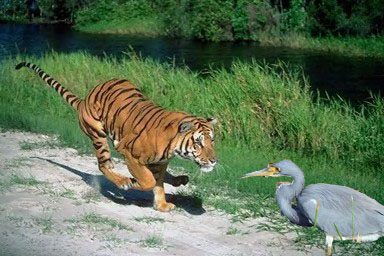

In [ ]:
Image.open('SelectedSpliced/Sp_D_CRN_A_ani0036_ani0066_0372.jpg')

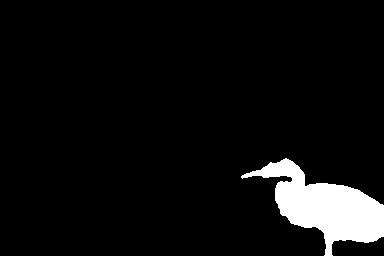

In [ ]:
Image.open('SelectedSGTs/Sp_D_CRN_A_ani0036_ani0066_0372_gt.png')

### Data Prep

In [ ]:
X = []
Y = []

#### ELA Threshold - Mask

In [ ]:
def thresholdMask(img):
    imgarr=np.array(img)
    thres=92
    arr=[[0]*256]*256
    masked=np.array(arr)
    for i in range(256):
        for j in range(256):
            if imgarr[i][j]>thres:
                masked[i][j]=1
    return masked

In [ ]:
for i in splicedIMG:
  img=convert_to_ela_image('SelectedSpliced/'+str(i), 90).resize((256,256))
  img=img.getchannel('B')
  X.append(np.array(img)/np.max(img))

for i in splicedGT:
  lbl=ImageOps.grayscale(Image.open('SelectedSGTs/'+str(i)).resize((256,256)))
  Y.append(np.array(lbl)/np.max(lbl))

In [ ]:
X = np.array(X)
Y = np.array(Y)

In [ ]:
X.shape

(202, 256, 256)

In [ ]:
Y.shape

(202, 256, 256)

In [ ]:
X = X.reshape(-1, 256,256, 1)
Y = Y.reshape(-1, 256,256, 1)

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2)

In [ ]:
X_train.shape

(161, 256, 256, 1)

In [ ]:
X_val.shape

(41, 256, 256, 1)

###Segmenter

In [ ]:
model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'same', 
                 activation ='relu', input_shape = (256,256,1)))
model.add(BatchNormalization())
model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(UpSampling2D(size = (2,2)))
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'same', 
                 activation ='relu'))
model.add(BatchNormalization())

model.add(UpSampling2D(size = (2,2)))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same', 
                 activation ='relu'))
model.add(BatchNormalization())

model.add(UpSampling2D(size = (2,2)))
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'same', 
                 activation ='relu'))
model.add(BatchNormalization())

model.add(UpSampling2D(size = (2,2)))
model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'same', 
                 activation ='relu'))
model.add(BatchNormalization())

model.add(Conv2D(filters = 1, kernel_size = (1,1), activation = 'sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 256, 256, 16)      160       
_________________________________________________________________
batch_normalization_16 (Batc (None, 256, 256, 16)      64        
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 256, 256, 16)      2320      
_________________________________________________________________
batch_normalization_17 (Batc (None, 256, 256, 16)      64        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 128, 128, 32)      4640      
_________________________________________________________________
batch_normalization_18 (Batc (None, 128, 128, 32)     

In [ ]:
model.compile(optimizer = Adam(lr = 0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
model.load_weights('segmenter_weights.h5')

In [ ]:
model_checkpoint = ModelCheckpoint('segmenter_weights.h5', monitor='val_accuracy',verbose=1, save_best_only=True)

In [ ]:
#Do not touch the graph below. Train again by copying the cell at a different place.

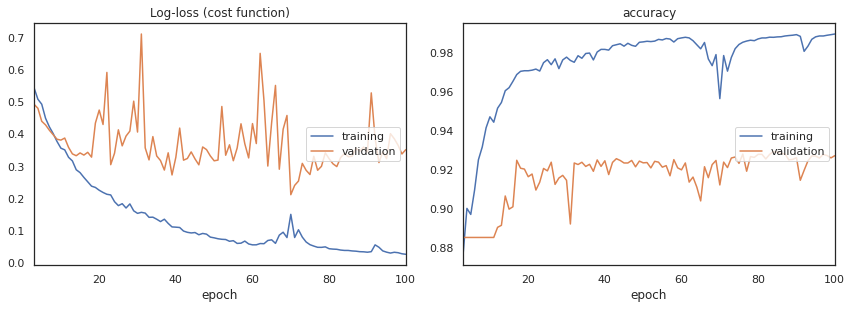

Log-loss (cost function):
training   (min:    0.027, max:    0.660, cur:    0.027)
validation (min:    0.212, max:    0.711, cur:    0.352)

accuracy:
training   (min:    0.711, max:    0.989, cur:    0.989)
validation (min:    0.885, max:    0.929, cur:    0.927)

Epoch 00100: val_accuracy did not improve from 0.92927
161/161 [==============================] - 2s 12ms/sample - loss: 0.0270 - accuracy: 0.9894 - val_loss: 0.3519 - val_accuracy: 0.9271


In [ ]:
model.fit(X_train, Y_train, validation_data = (X_val, Y_val), batch_size=4, epochs=100, verbose=1, callbacks=[PlotLossesCallback(),model_checkpoint])

In [ ]:
model_checkpoint = ModelCheckpoint('segmenter_weights.h5', monitor='val_accuracy',verbose=1, save_best_only=True)

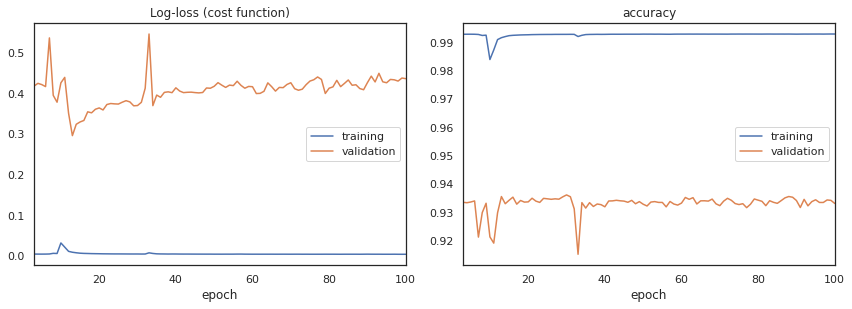

Log-loss (cost function):
training   (min:    0.004, max:    0.032, cur:    0.004)
validation (min:    0.296, max:    0.547, cur:    0.437)

accuracy:
training   (min:    0.984, max:    0.993, cur:    0.993)
validation (min:    0.915, max:    0.936, cur:    0.933)

Epoch 00100: val_accuracy did not improve from 0.93618
161/161 [==============================] - 2s 14ms/sample - loss: 0.0044 - accuracy: 0.9930 - val_loss: 0.4367 - val_accuracy: 0.9332


In [ ]:
model.fit(X_train, Y_train, validation_data = (X_val, Y_val), batch_size=4, epochs=100, verbose=1, callbacks=[PlotLossesCallback(),model_checkpoint])

In [ ]:
#cp 'segmenter_weights.h5' '/content/gdrive/My Drive/Colab Notebooks/segmenter_weights.h5'

In [ ]:
model.evaluate(X_val,Y_val)

41/41 [==============================] - 0s 4ms/sample - loss: 0.3705 - accuracy: 0.9362


[0.37053856471689733, 0.9361818]

In [ ]:
model.evaluate(X_train,Y_train)

161/161 [==============================] - 0s 3ms/sample - loss: 0.0048 - accuracy: 0.9929


[0.0047747392051199575, 0.99291354]

### Testing

In [ ]:
n=1

In [ ]:
testGT=Y[n].reshape(256,256)

In [ ]:
test=X[n].reshape(-1,256,256,1)

In [ ]:
result=model.predict(test)

In [ ]:
result=result.reshape(256,256)

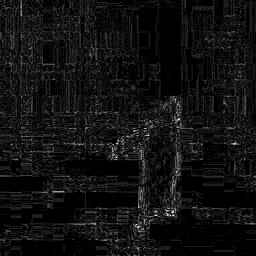

In [ ]:
Image.fromarray((test*255).reshape(256,256).astype('uint8'))

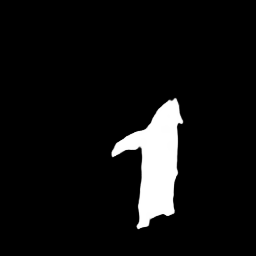

In [ ]:
Image.fromarray((result*255).astype('uint8'))

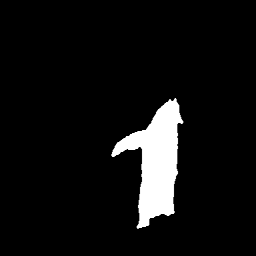

In [ ]:
Image.fromarray((testGT*255).astype('uint8'))

In [ ]:
from math import log10, sqrt

def PSNR(original, compressed): 
    mse = np.mean((original - compressed) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return psnr 

In [ ]:
PSNR(testGT,test.reshape(256,256))

60.48785961950722

In [ ]:
def convert_to_ela_image(path, quality,intensity=None):
      filename = path
      resaved_filename = 'tempresaved.jpg'
      ELA_filename = 'tempela.png'
      
      im = Image.open(filename).convert('RGB')
      im.save(resaved_filename, 'JPEG', quality = quality)
      resaved_im = Image.open(resaved_filename)
      
      ela_im = ImageChops.difference(im, resaved_im)
      
      extrema = ela_im.getextrema()
      max_diff = max([ex[1] for ex in extrema])
      if max_diff == 0:
         max_diff = 1
      scale = 255.0 / max_diff
      if intensity==None:
         ela_im = ImageEnhance.Brightness(ela_im).enhance(scale)
      else:
         ela_im = ImageEnhance.Brightness(ela_im).enhance(intensity)
      return  ela_im

In [ ]:
img=convert_to_ela_image('SelectedSpliced/Sp_D_CNN_A_art0024_ani0032_0268.jpg', 90).resize((256,256))
img=img.getchannel('B')
np.sum(np.array(img)/np.max(img))

4400.139896373057

In [ ]:
!apt install neofetch

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  neofetch
0 upgraded, 1 newly installed, 0 to remove and 14 not upgraded.
Need to get 74.8 kB of archives.
After this operation, 365 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 neofetch all 3.4.0-1 [74.8 kB]
Fetched 74.8 kB in 0s (212 kB/s)
Selecting previously unselected package neofetch.
(Reading database ... 144793 files and directories currently installed.)
Preparing to unpack .../neofetch_3.4.0-1_all.deb ...
Unpacking neofetch (3.4.0-1) ...
Setting up neofetch (3.4.0-1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [ ]:
!neofetch

            .-/+oossssoo+/-. 
        `:+ssssssssssssssssss+:` 
      -+ssssssssssssssssssyyssss+- 
    .ossssssssssssssssssdMMMNysssso. 
   /ssssssssssshdmmNNmmyNMMMMhssssss/ 
  +ssssssssshmydMMMMMMMNddddyssssssss+ 
 /sssssssshNMMMyhhyyyyhmNMMMNhssssssss/ 
.ssssssssdMMMNhsssssssssshNMMMdssssssss. 
+sssshhhyNMMNyssssssssssssyNMMMysssssss+ 
ossyNMMMNyMMhsssssssssssssshmmmhssssssso 
ossyNMMMNyMMhsssssssssssssshmmmhssssssso 
+sssshhhyNMMNyssssssssssssyNMMMysssssss+ 
.ssssssssdMMMNhsssssssssshNMMMdssssssss. 
 /sssssssshNMMMyhhyyyyhdNMMMNhssssssss/ 
  +sssssssssdmydMMMMMMMMddddyssssssss+ 
   /ssssssssssshdmNNNNmyNMMMMhssssss/ 
    .ossssssssssssssssssdMMMNysssso. 
      -+sssssssssssssssssyyyssss+- 
        `:+ssssssssssssssssss+:` 
            .-/+oossssoo+/-. 
root@30bc3d51d4b5 
----------------- 
OS: Ubuntu 18.04.5 LTS x86_64 
Host: Google Compute Engine 
Kernel: 4.19.112+ 
Uptime: 48 mins 
Packages: 1238 
Shell: bash 4.4.20 
Terminal: jupyter-noteboo 
CPU: Intel Xeon (2) @ 2.200GHz 
Mem